In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))

In [2]:
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [3]:
rasqual_caQTL_coacc = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, outlogdir,
                         nsamples=10, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$Chromosome[x], ":",snp_counts$position[x]-1 ,"-",snp_counts$position[x])
outfile = paste0(outdir, "/",  snp_counts$coacPeak[x])   
outlog  = paste0(outlogdir,"/",  snp_counts$coacPeak[x], ".log")
ss      = str_split_fixed( str_split_fixed(snp_counts$coacPeak[1], ":", 2)[,2], "-",2)
    
system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', 1 ,
'-m', 0 , 
'-s', as.numeric(ss[1]) +1,
'-e', as.numeric(ss[2]) , 
'-f', snp_counts$coacPeak[x],
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
#'--min-coverage-depth 6',
'>', outfile, "2>", outlog))
    
}

In [4]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/')

In [5]:
allqtls = read.table ("summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv", header=T)
allqtls = subset(allqtls, flag_fdr10==TRUE & exclude==FALSE)

In [6]:
#coacc = read.table( "run_cicero_paola/final_conns/coaccessible.matrix", header=T)
coacc = read.table( "run_cicero_paola/final_conns/coaccessible.matrix4s", header=T)

In [8]:
celltypes = c('b','mono','nk','t')

In [9]:
colSums(!is.na(coacc[,celltypes]))

b   mono     nk      t 
158935 254692 152213 327048

In [46]:
###### set parmetes here ######
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/broad/'
#celltypes   = list.files(maindir)[!grepl(".txt", list.files(maindir))]
P           =  FALSE ## permutation?  ## not necessary with the new vcf files
folder_name = 'coacc_run1_all'
L           =  FALSE ## report only lead?
nsamples    = 10
####################################

setwd(maindir)

In [47]:
for (c in celltypes ){
    
## 1) Select caQTL to test
results = subset(allqtls, cell==c)
results$peak = gsub( ":|-",  "_", results$Feature)

## 2) Pair with the coaccessible peak
cic = coacc[!is.na(coacc[,c]), c('Peak1','Peak2', c)]
#caca = cic[apply(cic[,1:2], 1, function(x)  sum(x %in% results$peak)==2 ),]
cic = cic[apply(cic[,1:2], 1, function(x)  sum(x %in% results$peak)==1 ),]
cic$Feature = unlist(apply(cic[,1:2], 1, function(x)  x [x %in% results$peak]))
cic$coacPeak = unlist(apply(cic[,1:2], 1, function(x)  x [!(x %in% results$peak)]))
cic = cic[!duplicated(cic),]                         

fe = str_split_fixed(cic$Feature,"_",3)
co = str_split_fixed(cic$coacPeak,"_",3)
tab = data.frame(Feature = paste0(fe[,1],":" ,fe[,2],"-",fe[,3]), 
                 coacPeak = paste0(co[,1],":" ,co[,2],"-",co[,3]), coaccess = cic[,c], 
                 dist =abs(as.numeric(fe[,3]) - as.numeric(co[,3])) )

inp  = read.table(paste0( c, "/counts.",c, ".txt" ), row.names=1)

tab = subset(tab, coacPeak %in% rownames(inp))
tab = merge(tab, results, by="Feature")

indexes =  match ( tab$coacPeak,rownames(inp))

vcf_dir  = paste0(c, '/vcfs_peaksonly/' )
vcf_file = paste0(vcf_dir,  'full.ase.filtered.vcf.gz' )


counts      = paste0( c, "/counts.",c, ".bin" )
offsets     = paste0( c, "/size_factors.",c, ".bin" )
covariates  = paste0( c, "/covariates2.",c, ".bin" )

out_dir = paste0(c,"/coaccessible_qtls/")
# dir.create(out_dir)
outdir = paste0(out_dir, folder_name)
 dir.create(outdir)
outlogdir = paste0(outdir, "/logs")
dir.create(outlogdir)
write.table(tab, paste0(out_dir,   "Tested_coaccessible_sites4s.txt") , row.names=F, sep="\t", quote=F)


mclapply(1:nrow(tab), function(x) rasqual_caQTL_coacc(x, tab, counts, offsets, covariates, nsamples=nsamples, 
                                                vcf=vcf_file, outdir=outdir, outlogdir=outlogdir , 
                                                      lead=L, permut=P), mc.cores = 40)
}


Warning message in dir.create(outdir):
“'b/coaccessible_qtls/coacc_run1_all' already exists”
Warning message in dir.create(outdir):
“'mono/coaccessible_qtls/coacc_run1_all' already exists”
Warning message in dir.create(outdir):
“'nk/coaccessible_qtls/coacc_run1_all' already exists”
Warning message in dir.create(outdir):
“'t/coaccessible_qtls/coacc_run1_all' already exists”


In [48]:
for (c in celltypes){
    cat (c, "\n")
    outer_dir = paste0(c,"/coaccessible_qtls/")
    outdir    = paste0(outer_dir, folder_name)
    tabname   = paste0(outer_dir, "/Results_", folder_name, ".tsv")
    
        
        system(paste0("cat ", outdir,  "/* > ", tabname))
        
         results           = read.table(tabname, fill=T)
         colnames(results) = coln
         results           = subset(results,results$rsID !="SKIPPED")
         results$P_VAl     = pchisq(results[,11], 1, lower=F)
         write.table(results, tabname, sep="\t", quote=F)

}


b 
mono 
nk 
t 


In [49]:
for (c in celltypes){
    out_dir = paste0(c,"/coaccessible_qtls/")
    logdir  = paste0( out_dir, folder_name , "_logs")
    dir.create(logdir)
    outdir = paste0(out_dir, folder_name)
    outlogdir = paste0(outdir, "/logs")

        files = na.omit(list.files(outlogdir)[sapply(paste(outlogdir, list.files(outlogdir),sep="/"), file.size) >0])
 if(length(files)>0) {      
    error_files= paste(outlogdir, files, sep="/")
     for (err in error_files){
     system(paste("mv", err, logdir))
    }
     }
    system(paste("rm -r",outlogdir ))
    
            }
    
    

Warning message in dir.create(logdir):
“'b/coaccessible_qtls/coacc_run1_all_logs' already exists”
Warning message in dir.create(logdir):
“'mono/coaccessible_qtls/coacc_run1_all_logs' already exists”
Warning message in dir.create(logdir):
“'nk/coaccessible_qtls/coacc_run1_all_logs' already exists”
Warning message in dir.create(logdir):
“'t/coaccessible_qtls/coacc_run1_all_logs' already exists”


In [36]:
c

[1] "t"

In [48]:
# for (c in celltypes){
#     for ( n in 1:22){
#         chrom  = paste0("chr", n)
#         outdir = paste( c, folder_name , chrom, sep ="/")         
#         system(paste0("rm -r ", outdir))
        
#             }
#     system(paste0("rm -r ", c, "/", folder_name))
#  }

### Calculte empirical q-value from the permutations.
see: https://github.com/natsuhiko/rasqual/issues/21

In [37]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [50]:
df = data.frame()
for (c in celltypes) {
results       = read.table(paste0(c, "/coaccessible_qtls/Results_coacc_run1_all.tsv"), header=T, stringsAsFactors = F, fill=T)
random        = read.table(paste0(c, "/coaccessible_qtls/Results_coacc_perm1_lead.tsv"), header=T, stringsAsFactors = F, fill=T)
random2       = read.table(paste0(c, "/coaccessible_qtls/Results_coacc_perm2_lead.tsv"), header=T, stringsAsFactors = F, fill=T)
results       = results[order(results$P_VAl),]
results_lead  = results[!duplicated(results$Feature),]
 
    
orig_res = read.table(paste0(c, "/coaccessible_qtls/Tested_coaccessible_sites4s.txt"), header=T)
results_lead = subset(results_lead, Feature %in% orig_res$coacPeak)
    
    
thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
thresh20       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.20) 

results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
results_lead$flag_fdr20 = 10^(results_lead$Log10_qval) < thresh20
df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                   thresh20, sum(results_lead$flag_fdr20, na.rm=T)))

write.table(results_lead, paste0(c, "/coaccessible_qtls/Results_coacc_run1_4s.tsv"),sep="\t", quote=F, row.names=F)    

}
rownames(df) = celltypes
colnames(df) = c('pval_fdr10%', 'caQTL_fdr10%', 'pval_fdr05%', 'caQTL_fdr05%','pval_fdr20%', 'caQTL_fdr20%')

In [51]:
head(df)

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr20%,caQTL_fdr20%
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
b,0.000000000,0,0.000000000,0,0.03879057,5
mono,0.000000000,0,0.000000000,0,0.00000000,0
nk,0.037471138,16,0.025473011,10,0.04900932,25
t,0.003643791,2,0.003643791,2,0.02111833,54


### Plot correlation

In [52]:
library(scales)

In [53]:
annot = read.table("/nfs/lab/projects/pbmc_snATAC/analysis_v2/run_cicero_paola/final_conns/peak_filtered.annotated.coaccessible.matrix", header=T)

In [54]:
loops = paste(annot [,1], annot[,2], sep="_")

In [55]:
annot$loops = loops

In [56]:
celltypes

[1] "b"    "mono" "nk"   "t"

In [73]:
head(m)

,coacPeak,varID,Feature,Effect_size.x,coaccess,rsID,dist,peak,Effect_size.y,P_VAl,flag_fdr20,loops,cell
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<chr>
11287,chr5:180259518-180259962,chr5:180046209:C:T,chr5:180045837-180046502,0.605030,0.13776666,rs446003,213460,chr5_180045837_180046502,0.643434,0.001607354,TRUE,chr5_180045837_180046502_chr5_180259518_180259962,t
2472,chr11:85491836-85493072,chr11:85460909:G:C,chr11:85467369-85467794,0.421823,0.20504717,rs613973,25278,chr11_85467369_85467794,0.343554,0.005214914,TRUE,chr11_85467369_85467794_chr11_85491836_85493072,t
3700,chr14:32396406-32397082,chr14:32414145:C:A,chr14:32413489-32414663,0.752060,0.18365939,rs1278926,17581,chr14_32413489_32414663,0.743535,0.006790374,TRUE,chr14_32396406_32397082_chr14_32413489_32414663,t
1198,chr10:126377332-126378010,chr10:126840928:A:G,chr10:126848835-126850448,0.613832,0.36744513,rs1693658,472438,chr10_126848835_126850448,0.601313,0.007971481,TRUE,chr10_126377332_126378010_chr10_126848835_126850448,t
12777,chr7:12428587-12429088,chr7:12443688:A:G,chr7:12442949-12444072,0.724666,0.10732220,rs17443848,14984,chr7_12442949_12444072,0.644399,0.009422707,TRUE,chr7_12428587_12429088_chr7_12442949_12444072,t
8599,chr20:25241431-25242210,chr20:25849068:C:G,chr20:25840471-25840819,0.658942,0.05345598,rs3949256,598609,chr20_25840471_25840819,0.367492,0.009499438,TRUE,chr20_25241431_25242210_chr20_25840471_25840819,t


In [78]:
signif = data.frame()
pdf("../../figures/Correlation_coacc_qtls_4s.pdf")
par(mfrow=c(2,2), mar =c(6,4,4,6))
for (c in celltypes){
coac_res = read.table(paste0(c, "/coaccessible_qtls/Results_coacc_run1_4s.tsv"), header=T)

orig_res = read.table(paste0(c, "/coaccessible_qtls/Tested_coaccessible_sites4s.txt"), header=T)

m = merge(orig_res[,c('coacPeak','varID','Feature', 'Effect_size', 'coaccess', 'rsID', "dist", "peak")],
         coac_res[,c('Feature', 'rsID', 'Effect_size', 'P_VAl','flag_fdr20')], by=1:2)

m    = m[order(m$P_VAl),]
#m    = m[order(-m$coaccess),]

#m = subset(m,coaccess>0.2 )    
    
## filter for PP and CP
df   = paste( gsub(":|-", "_", m$coacPeak) , gsub(":|-", "_", m$Feature), sep="_")
ddf  = str_split_fixed(df, "_", 6 )
test = t(apply(ddf[,c(2,3,5,6)], 1, function(x) sort(as.numeric(x))))
lp   = paste(ddf[,1], test[,1], test[,2], ddf[,1], test[,3], test[,4], sep="_")
m$loops = lp
m       = m[lp %in% loops,]
#m       = merge(m, annot, by="loops")
#m = m[m$peak != apply(m[,c('prom_side', 'Peak1', 'Peak2')],1 ,function(x) x[2:3][(x[1]=="B")+1]),]
               
               
m$cell = c
  cat (c," ", nrow(m), "\n")             
signif = rbind(signif, subset(m,flag_fdr20==TRUE ))

msub = subset(m , !duplicated(m$Feature))

co = cor.test(msub$Effect_size.x, msub$Effect_size.y, method="pearson")$estimate

plot(Effect_size.y~Effect_size.x, msub, main =c, cex=0.8, xlim=c(0.1, 0.9),
     pch = 19, col=alpha('#756bb1',0.5), xlab = "Effect size caQTL peak", 
     ylab ="Effect size coacc. peak")
abline(h=0.5, v=0.5)
abline(lm(Effect_size.y~Effect_size.x, msub), lwd=2)
mtext(paste("r=", round(co,2), "n=", nrow(msub)))
}
dev.off()

b   1712 
mono   4752 
nk   2222 
t   6272 


png 
  2

In [58]:
signif_uni = subset(signif , !duplicated(signif$Feature))

In [79]:
dim(signif_uni)

[1] 19 13

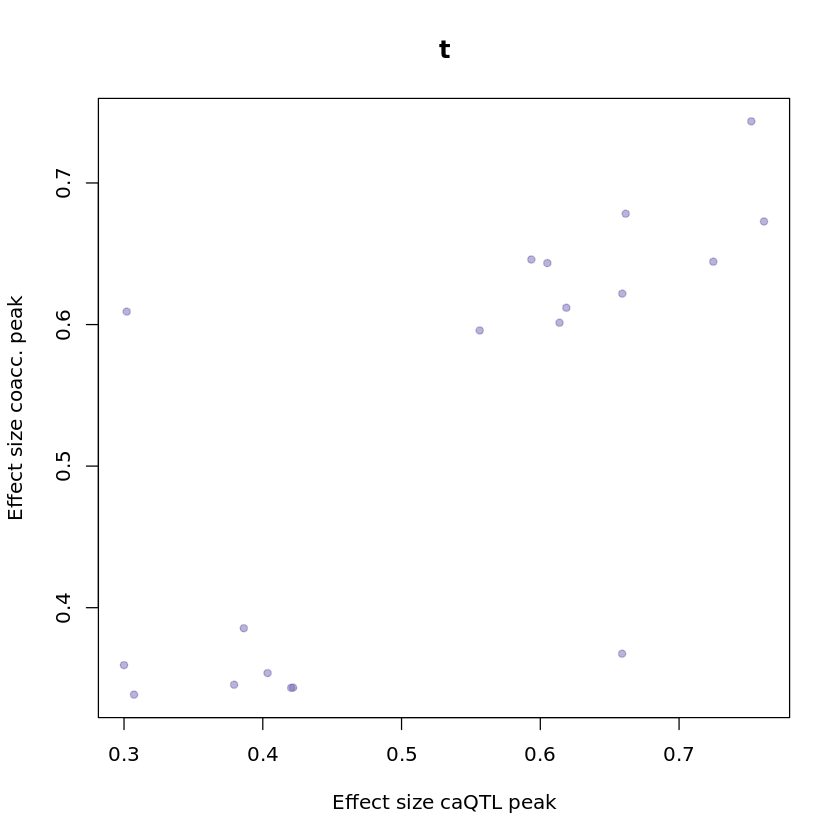

In [59]:
plot(Effect_size.y~Effect_size.x, signif_uni, main =c, cex=0.8,
     pch = 19, col=alpha('#756bb1',0.5), xlab = "Effect size caQTL peak", 
     ylab ="Effect size coacc. peak")


In [75]:
pdf("../../figures/Correlation_coacc_qtls_coaccess_thresholds_4ss.pdf")
par(mfrow=c(4,5), mar=c(3,2,3,1))
for (c in celltypes){
coac_res = read.table(paste0(c, "/coaccessible_qtls/Results_coacc_run1_4s.tsv"), header=T)

orig_res = read.table(paste0(c, "/coaccessible_qtls/Tested_coaccessible_sites4s.txt"), header=T)

m = merge(orig_res[,c('coacPeak','varID','Feature', 'Effect_size', 'coaccess', 'rsID', "dist")],
         coac_res[,c('Feature', 'rsID', 'Effect_size', 'P_VAl','flag_fdr20')], by=1:2)

m    = m[order(m$P_VAl),]
m    = m[order(-m$coaccess),]

## filter for PP and CP
df   = paste( gsub(":|-", "_", m$coacPeak) , gsub(":|-", "_", m$Feature), sep="_")
ddf  = str_split_fixed(df, "_", 6 )
test = t(apply(ddf[,c(2,3,5,6)], 1, function(x) sort(as.numeric(x))))
lp   = paste(ddf[,1], test[,1], test[,2], ddf[,1], test[,3], test[,4], sep="_")
m$loops = lp
msub    = m[lp %in% loops,]

msub$cell = c

#msub$dist_quantiles = cut(msub$dist/1000, breaks=c(10,50,100, 200, 350, 1000))
msub$dist_quantiles = cut(msub$coaccess, breaks=c(0.05,0.1,0.2, 0.3, 0.4, 1))

sp = split(msub, msub$dist_quantiles)


for (j in 1:5){
mdist = sp[[j]]
mdist  = subset(mdist , !duplicated(mdist$Feature))
co = cor.test(mdist$Effect_size.x, mdist$Effect_size.y, method="pearson")$estimate

plot(Effect_size.y~Effect_size.x, mdist, main =mdist[1,'dist_quantiles'], cex=0.8,
     pch = 19, col=alpha('#756bb1',0.5), xlab = "Effect size caQTL peak",  xlim=c(0.15, 0.85),
     ylab ="Effect size coacc. peak")
abline(h=0.5, v=0.5)
abline(lm(Effect_size.y~Effect_size.x, mdist), lwd=2)
mtext(paste("r=", round(co,2), "n=", nrow(mdist)), cex = 0.75)
}
               }
dev.off()

png 
  2

In [61]:
signif       = merge(signif, annot, by="loops")
signif = signif[signif$peak != apply(signif[,c('prom_side', 'Peak1', 'Peak2')],1 ,function(x) x[2:3][(x[1]=="B")+1]),]
